# Finding the Optimal Learning Rate on K-MNIST using Baysian Optimization

Within this blog, I am giving a short introduction into Bayesian optimization to find a near optimal learning rate. There exists a lot of great tutorials regarding the theory of Bayesian optimization. The main objective of this blog is to give a hands-on tutorial for hyperparameter optimization. As I will cover the theory only very briefly, it is recommend to read about the latter first before going through this tutorial. I am training a small ResNet implemented in PyTorch on the Kuzushiji-MNIST (or K-MNIST) dataset. This tutorial covers the following steps:

1. **Download and import the K-MNIST dataset into our project**
2. **Define a small ResNet in Pytorch**
3. **Define everything needed for Bayesian Optimization**
4. **Using Bayesian Optimization to find the optimal learning rate**
4. **Some practical approaches for learning rate optimization (logarithmic feature transformation)**

What this tutorial will **not** cover:
* Introduction to PyTorch
* Gaussian Processes

A basic understanding of Python and PyTorch are required.
***
But first things first, let's make some general imports and set the seed so we do not need to worry about them later:


# Finding the Optimal Learning Rate on K-MNIST using Baysian Optimization

Within this blog, I am giving a short introduction into Bayesian
optimization to find a near optimal learning rate. There exists a
lot of great tutorials regarding the theory of Bayesian optimization.
The main objective of this blog is to give a hands-on tutorial for
hyperparameter optimization. As I will cover the theory only very briefly,
it is recommend the read about the latter first before going through this
tutorial. I am training a small ResNet implemented in PyTorch on the
Kuzushiji-MNIST (or K-MNIST) dataset. This tutorial covers the following
steps:
    
1. **Download and import the K-MNIST dataset into our project**
2. **Define a small ResNet in Pytorch**
3. **Define everything needed for Bayesian Optimization**
4. **Using Bayesian Optimization to find optimal learning rate**
4. **Some practical approaches for learning rate optimization**

What this tutorial will **not** cover:
* Introduction to PyTorch
* Gaussian Processes

***
A basic understanding of Python and PyTorch are required. But first things first, let's make some general imports and set some seeds so we do not need to worry about them later:


In [1]:
import os 
import torch 
import torchvision
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# set seeds 
seed=94
np.random.seed(seed)
torch.manual_seed(seed)

Done! So let's dive into the first step...
***
## Download and import the K-MNIST dataset 

As mentioned before, we are training on the K-MNIST dataset. Luckily, this dataset is part of the `torchvision` package, which we have just imported! This makes it very straightforward to create a training and validation dataset as the dataset is downloaded autonomously (if it is not already downloaded) and imported in the desired format. We can pass each dataset to PyTorch's `DataLoader`, which represents an iterable over the dataset. 

In [2]:
# define a batch size 
batch_size = 32

# define transformations we want to apply to our images
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# create a dataset and dataloader for training
train_ds = torchvision.datasets.KMNIST(root='./data', train=True,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

# create a dataset and dataloader for validation
val_ds = torchvision.datasets.KMNIST(root='./data', train=False,
                                     download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

That's it! We have just prepared our data. Let's see how our images look like.

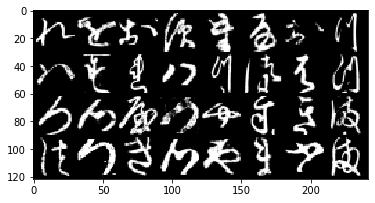

In [4]:
def show_batch(images):
    """
    Prints one batch of images in a single image.

    Parameters
    ----------
    images:
        Batch of images in training data from the DataLoader.
    """
    images = torchvision.utils.make_grid(images).numpy()
    plt.imshow(np.transpose(images, (1, 2, 0)))
    plt.show()

# get one batch
images, labels = next(iter(train_loader))

# plot 
show_batch(images)

Looks like some japanese characters! **Make sure to run the DataLoader cell again, as we took one batch already.**

It's time to create the model.
___
## Defining a small ResNet

We use a small ResNet9 (8 convolutional layers and 1 fully-connected layer) as it is small yet provides reasonable performance. This is the structure of the network:

<br/>
<img src="img/ResNet9.png" alt="drawing" width="400"/>
<br/>

#### Convolutional Blocks
In my eyes, it looks less cluttered if we aggregate multiple layers to blocks. So let's start by defining the convolutional blocks shown above. These consist of a convolutional layer, batch normalization, ReLU activation and (eventually) MaxPooling:

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    """
    Block consisting of a convolutional layer, batch-norm, relu activation and max-pooling (if needed).
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, pool=False, pool_kernel_size=2):
        super(ConvBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.conv_bn = nn.BatchNorm2d(out_channels)

        if pool:
            self.pooling = nn.MaxPool2d(pool_kernel_size)
        else:
            self.pooling = None

    def forward(self, x):
        out = F.relu(self.conv_bn(self.conv(x)))
        if self.pooling is not None:
            out = self.pooling(out)
        return out

#### Residual Blocks

Next, let's define the residual blocks shown above. These blocks consists of two convolutional blocks without MaxPooling:

In [6]:
class ResidualBlock(nn.Module):
    """
    Residual block consisting of 2 convolutional blocks.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ResidualBlock, self).__init__()

        self.conv_block1 = ConvBlock(in_channels, out_channels, kernel_size, padding)
        self.conv_block2 = ConvBlock(in_channels, out_channels, kernel_size, padding)

    def forward(self, x):
        residual = x
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        out += residual
        return out

### ResNet9

Now it is straightforward to define our ResNet. Simply concatenate the blocks as shown above and add an additional MaxPolling and a fully-connected layer at the end. Note that we do not add a Softmax layer at the end, as the Cross-Entropy loss, which we are going to use later, includes this already:

In [7]:
class ResNet9(nn.Module):
    """
    ResNet consisting of 8 convolutional layers, 1 fully-connected layer and some forward paths for residuals.
    """
    def __init__(self, in_channels, num_classes):
        super(ResNet9, self).__init__()

        # 1st and 2nd convolutional layer
        self.conv_block1 = ConvBlock(in_channels, 64)
        self.conv_block2 = ConvBlock(64, 128, pool=True)

        # residual block consisting of the 3rd and 4th convolutional layer
        self.res_block1 = ResidualBlock(128, 128)

        # 5th and 6th convolutional layers
        self.conv_block3 = ConvBlock(128, 256, pool=True)
        self.conv_block4 = ConvBlock(256, 512, pool=True)

        # residual block consisting of the 7th and 8th convolutional layer
        self.res_block2 = ResidualBlock(512, 512)

        # final fully-connected layer
        self.classifier = nn.Sequential(nn.MaxPool2d(3),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        out = self.res_block1(out)
        out = self.conv_block3(out)
        out = self.conv_block4(out)
        out = self.res_block2(out)
        out = self.classifier(out)
        return out

That's it! We have our model now. So let's dive into the next step.

___

## Bayesian Optimization

A naive solution to find promising learning rates is to sample learning rates equidistantly or randomly in the search space. This is the concept behind grid and random search. While this is easy to use when function evaluation is cheap, it becomes infeasible when the function evaluation is costly. The latter is typically the case in deep learning. However, we can do better using Bayesian optimization. Bayesian optimization uses probability theory to predict the *most promising* learning rate candidate based on previously evaluated learning rates. 

### Objective Function and Surrogate Model

But how do we predict the most promising next learning rate? Well, if you think about it, what we actually would like to know is some kind of function, which maps a learning rate to a performance metric, for instance the loss. If we would have such a function, we can simply take the minimum of it to find the best learning rate possible. Let's call the latter the *objective function*. Obviously, we don't have access to the objective function (otherwise, you wouldn't be here). And evaluating the objective function for a huge number of learning rates is also infeasible, as we already said. However, what we can do is to evaluate a few learning rates and try to fit a *model* to the objective function. The key idea is to fit the model until it decently represents the objective function. Then, we can instead search for the model's minimum to find a surrogate optimal learning rate. This is why we call such a model a *surrogate model* in Bayesian optimization. We are going to use a *Gaussian Process (GP)* as our surrogate model. Without observation noise, a GP can be interpreted as an interpolator, which - in contrast to other interpolators - additionally gives us information about its uncertainty between two data samples. The uncertainty measure between two data samples is crucial and one of the most distinct features of Bayesian optimization. The latter is used to exert exploration in the search space(or rather the learning rate's space). The higher the uncertainty within a certain search space region the more exploration we need to do. Note that we are not going to implement GPs ourselves here. There are tons of libraries out there. Instead, we are using `sklearn`'s implementation, as shown later.

### Acquisition Function

Okay, assume for now that we have a surrogate model, which does not yet fits the objective function very well. How do we actually choose the next most promising learning rate to evaluate? This is where the *aquisition funtion* comes into play. We are using it to determine what learning rate is the most promising for the *current* GP fitting. Hence, the acquisition function can be interpreted as a one-step utility measure. A popular choice for the acquisition function is *Expected Improvement* (EI). For our task, the improvement is defined as the improvement over the current best learning rate. Hence, the improvement $I$ at time step $t$ is defined as  

\begin{equation}
I^{(t)}(\lambda) = \max (0, L_{inc}^{(t)} - L(\lambda)) \,, \label{eq:improvement}
\end{equation}

where $\lambda$ is the learning rate and $L_{inc}^{(t)}$ is the best loss experienced so far, which we call current incumbent. The corresponding learning rate is $\lambda_{inc}^{(t)} = \mathrm{argmin}_{\lambda' \in \mathcal{D}^{(t)}} L(\lambda')$, where $\mathcal{D}^{(t)}$ is the dataset containing all learning rates $\lambda'$ evaluated until time step $t$. This equation has an intuitive appeal; an improvement is achieved if our model predicts a loss smaller than the loss of the current incumbent. The best improvement possible can be achieved at the smallest loss, $\min\, L(\lambda)$.

The Expected Improvement additionally considers uncertainty and is defined - as the name suggests - as the expectation over the improvement $I^{(t)}$

\begin{equation}
u_{EI}^{(t)}(\lambda) = \mathop{\mathbb{E}}[I^{(t)}(\lambda)] = \int_{-\infty}^{\infty} p^{(t)}(L|\lambda) \times I^{(t)}(\lambda) \, dL \,.
\end{equation}

The latter can be computed in the closed form yielding:

\begin{equation}
u_{EI}^{(t)}(\lambda)=
\begin{cases}
\sigma^{(t)}(\lambda) [ Z \Phi(Z) + \phi(Z) ],& \text{if } \sigma^{(t)}(\lambda) > 0\\
0, & \text{if } \sigma^{(t)}(\lambda) = 0
\end{cases} \,,
\end{equation}

where $Z = \frac{L_{inc}^{(t)} - \mu^{(t)} (\lambda) - \xi }{\sigma^{(t)}(\lambda)}$ and $\xi$ is an optional exploration parameter. Note that $\phi$ is the PDF and $\Phi$ is the CDF of the standard normal distribution.

Now we can predict the next promising learning rate using our utility function

\begin{equation}
\lambda^{(t+1)} = \mathrm{argmax}_{\lambda \in \Lambda} u_{EI}^{(t)}(\lambda) \,,
\end{equation}

where $\Lambda$ is the search space.

That's it! We now know everything to write our own Bayesian optimizer. Let's start coding! We are going to define a class, which contains everything needed for Bayesian Optimization. Below, you can see the respective class. Let me first show you the code before explaining.

In [8]:
from scipy.stats import norm
from matplotlib import gridspec


class BayesianOptimizer:
    """
    This is a Bayesian Optimizer, which takes in a function to optimize, and finds the
    maximum value of a parameter within a bounded search space. It uses Expected Improvement as the
    acquisition function.

    Attributes
    ----------
    f: function
        Function to optimize.

    gp: GaussianProcessRegressor
        Gaussian Process used for regression.

    mode: str
        Either "linear" or "logarithmic".

    bound: list
        List containing the lower and upper bound of the search space. IMPORTANT: If mode is "logarithmic",
        the bound specifies the minimum and maximum exponents!

    size_search_space: int
        Number of evaluation points used for finding the maximum of the acquisition function. Can be interpreted
        as the size of our discrete search space.

    search_space: ndarray
        Vector covering the search space.
        
    gp_search_space: ndarray
        The search space of GP might be transformed logarithmically depending on the mode, which is why it
        might differ from our defined search space.

    dataset: list
        List containing all data samples used for fitting (empty at the beginning).

    states: list
        List containing the state of each iteration in the optimization process (used for later plotting).
    """

    def __init__(self, f, gp, mode, bound, size_search_space=250):
        if mode not in ["linear", "logarithmic"]:
            raise ValueError("%s mode not supported! Chose either linear or logarithmic." % mode)
        else:
            self.mode = mode
        self.f = f
        self.gp = gp
        self.min = bound[0]
        self.max = bound[1]
        self.size_search_space = size_search_space
        if mode == "linear":
            self.search_space = np.linspace(self.min, self.max, num=size_search_space).reshape(-1, 1)
            self.gp_search_space = self.search_space
        else:
            self.search_space = np.logspace(self.min, self.max, num=size_search_space).reshape(-1, 1)
            self.gp_search_space = np.log10(self.search_space)
        self.dataset = []
        self.states = []

    def _ei(self, c_inc, xi=0.05):
        """
        Expected Improvement (EI) acquisition function used for maximization.

        Parameters
        ----------
        c_inc: float
            Utility of current incumbent.

        xi: float
            Optional exploration parameter.

        Returns
        -------
        util: ndarray
            Utilization given the current Gaussian Process and incumbent
        """
        # calculate the current mean and std for the search space
        mean, std = self.gp.predict(self.gp_search_space, return_std=True)
        std = np.array(std).reshape(-1, 1)

        # calculate the utilization
        a = (mean - c_inc - xi)
        z = a / std
        util = a * norm.cdf(z) + std * norm.pdf(z)
        return util

    def _max_acq(self):
        """
        Calculates the next best incumbent for the current dataset D.

        Returns
        -------
        x_max: float
            Location (x-coordinate) of the next best incumbent

        util_max: float
            Utility of the next best incumbent.

        util: ndarray
            Utility function for the search space.
        """
        # get the value of the current best incumbent
        c_inc = np.max(np.array(self.dataset)[:, 1])

        # calculate the utility function
        util = self._ei(c_inc)

        # check if the utilization is all zero
        if np.all((util == 0.)):
            print("Warning! Utilization function is all zero. Returning a random point for evaluation.")
            x_max = self.search_space.reshape(-1)[np.random.randint(len(self.search_space))]
            util_max = 0.0
        else:
            # get the maximum's location and utility
            x_max = self.search_space.reshape(-1)[util.argmax()]
            util_max = util.max()

        return x_max, util_max, util

    def eval(self, n_iter=10, init_x_max=None):
        """
        Runs n_iter evaluations of function f and optimizes its parameter using Bayesian Optimization.

        Parameters
        ----------
        n_iter: int
            Number of iterations used for optimization

        init_x_max: float
            Initial guess of the parameter. If none, a random initial guess is sampled in the search space.

        Returns
        -------
        best_return_x: float
            Best sample found during optimization

        best_return_param:
            Parameters defining the best function (e.g., torch model).
        """

        # get a random initial value for the incumbent from our search space if not specified
        if not init_x_max:
            x_max = self.search_space[np.random.randint(len(self.search_space))]
            x_max = x_max.item()
        else:
            x_max = init_x_max

        # for storing the best return and some parameters specifying it
        best_return = None
        best_return_x = None
        best_return_param = None

        for i in range(n_iter):

            # print some information
            print("\nBO Iteration %d --> Chosen parameter: %f %s" % (i, x_max,
                                                                     "" if (init_x_max or i != 0) else "(randomly)"))
            # evaluate the function
            y, param = self.f(x_max)

            # store if it is the best
            if not best_return or y > best_return:
                best_return = y
                best_return_x = x_max
                best_return_param = param

            # add the new sample to the dataset
            self.dataset.append([x_max, y])

            # get all the data samples in the dataset
            xs = np.array(self.dataset)[:, 0].reshape(-1, 1)
            ys = np.array(self.dataset)[:, 1].reshape(-1, 1)

            # fit the GP with the updated dataset
            if self.mode == "linear":
                self.gp.fit(xs, ys)
            else:
                self.gp.fit(np.log10(xs), ys)

            # calculate the maximum utilization and its position
            x_max, util_max, util = self._max_acq()

            # save the state for later plotting
            self.states.append({"dataset": self.dataset.copy(),
                                "util": util,
                                "GP": self.gp.predict(self.gp_search_space, return_std=True)})

        return best_return_x, best_return_param

    def save_all_plots(self):
        """
        Saves all plots.
        """
        self.plot_all(show=False, save=True)

    def plot_all(self, show=True, save=True):
        """
        Plots all states/iterations made during optimization until now.

        Parameters
        ----------
        show: bool
            If true, plot is shown directly.

        save: bool
            If true, plot is saved.
        """
        for id, state in enumerate(self.states):
            self.plot_state(state, id, show=False, save=save)
        if show:
            plt.show()

    def plot_iteration(self, it, show=True, save=True):
        """
        Plots a certain iteration of the optimization process.

        Parameters
        ----------
        it: int
            Iteration of the optimization process

        show: bool
            If true, plot is shown directly.

        save: bool
            If true, plot is saved.
        """
        # get the corresponding state
        state = self.states[it]
        self.plot_state(state, it, show=show, save=save)

    def plot_state(self, state, fig_number, show=True, save=True, additional_func=None):
        """
        Plots a state of the optimization process.

        Parameters
        ----------
        state: dict
            Dictionary storing the dataset, utilization and GP describing one state during optimization.

        fig_number: int
            Id of the figure to plot.

        show: bool
            If true, plot is shown directly.

        save: bool
            If true, plot is saved.

        additional_func: (function, name)
            Additional function to plot.
        """

        # reshape search space as this is more convenient for plotting
        search_space = self.search_space.reshape(-1)

        # get all information of the corresponding state
        dataset = state["dataset"]
        util = state["util"].reshape(-1)
        gp = state["GP"]

        # create figure with two plots (ax1: GP fitting, ax2: utility function)
        figure = plt.figure(fig_number)
        gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[3, 1], figure=figure)
        ax1 = figure.add_subplot(gs[0])
        ax1.set_xticklabels([])  # turn off x labeling of upper plot
        ax1.set_title("Iteration %d" % fig_number)
        ax2 = figure.add_subplot(gs[1])

        # check if we need to set a logarithmic scale
        if self.mode == "logarithmic":
            ax1.set_xscale("log")
            ax2.set_xscale("log")

        # adjust borders to make it look better
        figure.subplots_adjust(bottom=.14, top=.95)

        # plot an additional function if given
        if additional_func:
            func, name = additional_func
            add_ys, _ = func(search_space)
            ax1.plot(search_space, add_ys, color="red", label=name)

        # plot the GP mean and std
        mu, std = gp
        mu = mu.reshape(-1)
        ax1.plot(search_space, mu,
                 color="blue", label="GP mean")
        ax1.fill_between(search_space,
                         mu - (std * 1), mu + (std * 1),
                         color="blue", alpha=0.3, label="GP std")

        # plot the dataset
        xs = np.array(dataset)[:, 0]
        ys = np.array(dataset)[:, 1]
        ax1.scatter(xs, ys, color="blue", label="Dataset")

        # plot the utility function
        ax2.plot(search_space, util, color="green", label="Utility function")
        ax2.fill_between(search_space,
                         np.zeros_like(util),
                         util.reshape(-1), alpha=0.3, color="green")

        figure.legend(loc="lower center", ncol=5 if additional_func else 4)

        if save:
            if not os.path.exists('./plots'):
                os.makedirs('./plots')
            fig_name = "./plots/BO_iteration_%d" % fig_number
            plt.savefig(fig_name)
        if show:
            plt.show()


The latter might look overwhelming at first, but it's actually straightforward.  Let's go through it function by function:

- `__init__()`: Here we initialize everything needed for our optimizer. The most important parts are the objective function (`self.f`), the Gaussian proccess (`self.gp`, defined later), the search space (`self.search_space`) and the search space for the Gaussian process (`self.gp_search_space`). But why do we have two search spaces? Well, you'll see later that it might be very beneficial to transform the GP's search space to a logarithmic space. More on that later!


- `_ei()`: This function defines the Expected Improvement (EI) acquisition function as described above.


- `_max_acq()`: This function calculates the best next incumbent based on the acquisition function. It simply calculates the utility function for our bounded and discrete search space $\Lambda$ (`self.search_space`) and determines where the maximum is.


- `eval()`:  This function evaluates the given function (`self.f`), fits the GP and determines the next incumbent using `_max_acq`. This is done for `n_iter` iterations.


Note that we have defined the Bayesian optimizer in a way that it is *maximizing* the objective function. That is, we need to take the negative of the objective function in case of a minimization problem (as it is the case for the loss). 

***
### Testing our Bayesian Optimizer 

Okay, now we have our Bayesian optimizer. Let's try it on a simple example. Therefore, we need to define an objective function first:

In [9]:
def objective(x):
    return x**2 * np.sin(5 * np.pi * x)**6.0, None

I have taken this objective function from another [blog](https://machinelearningmastery.com/what-is-bayesian-optimization/), which provides a great tutorial for basic Bayesian optimization. I can recommend to check it out as well! 

Note that the objective function returns a tuple consisting of the actual return of the function and an additional parameter, which is `None` in this case. The latter is used later when we want to know, which ResNet model yielded what loss in order to save its parameters and probably continue training from there on. Let's take a quick look at our objective function:


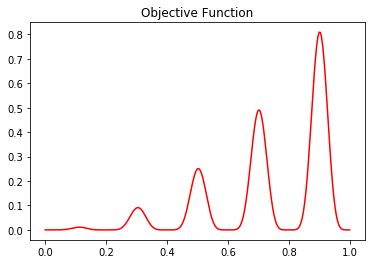

In [10]:
def plot_function(func, xs, fig_id=0):
    fig = plt.figure(0)
    ax = fig.add_subplot()
    ys, _ = objective(xs)
    ax.plot(xs, ys, color="red")
    ax.set_title("Objective Function")
    
xs = np.linspace(0,1, 250)
plot_function(objective, xs)
plt.show()

Okay, seems like our objective has several maxima from which the one at $x=0.9$ is the best in our interval. Let's see if our optimizer can find it.

However, we need to define the kernel, the Gaussian Process and some bounds first. We use a product kernel here consisting of a constant kernel and a Radial Basis Function (RBF) kernel. This is the default setting for sklearn as well.

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

kernel = C(1.0, (1e-5, 1e5)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel, n_restarts_optimizer=10)
bo = BayesianOptimizer(objective, gp, mode="linear", bound=[0, 1])

As mentioned above, we are not going to talk much about the theory of GPs. If you want to learn more, you might want to checkout this [blog](https://peterroelants.github.io/posts/gaussian-process-tutorial/). However, we are going to talk a bit about the importance of kernels later. 

For now, let's run 10 iterations of Bayesian optimization using our class and plot the results. Note that our optimizer stores everything we need to know about an iteration during the optimization process in `self.states`, so that plotting is easier.


BO Iteration 0 --> Chosen parameter: 0.500000 

BO Iteration 1 --> Chosen parameter: 0.000000 

BO Iteration 2 --> Chosen parameter: 0.510040 

BO Iteration 3 --> Chosen parameter: 0.337349 

BO Iteration 4 --> Chosen parameter: 1.000000 

BO Iteration 5 --> Chosen parameter: 0.771084 

BO Iteration 6 --> Chosen parameter: 0.160643 

BO Iteration 7 --> Chosen parameter: 0.646586 

BO Iteration 8 --> Chosen parameter: 0.891566 

BO Iteration 9 --> Chosen parameter: 0.867470 

--> Best Value found:  0.8915662650602408


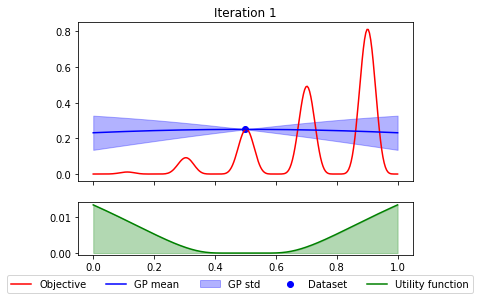

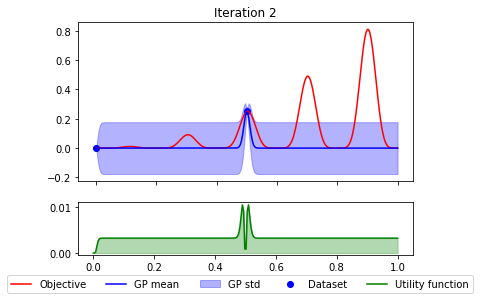

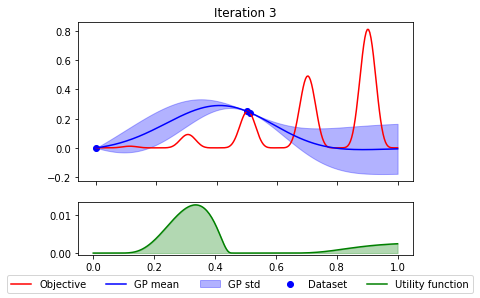

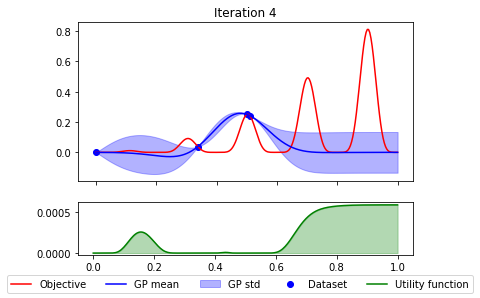

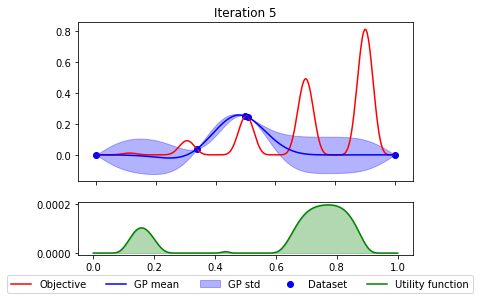

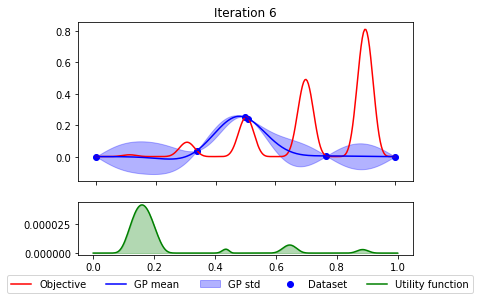

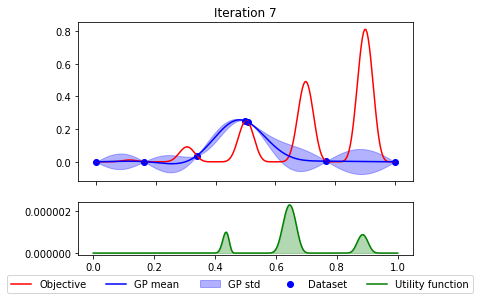

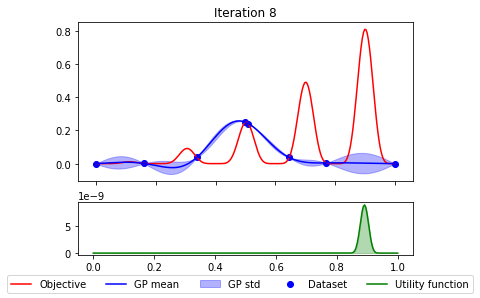

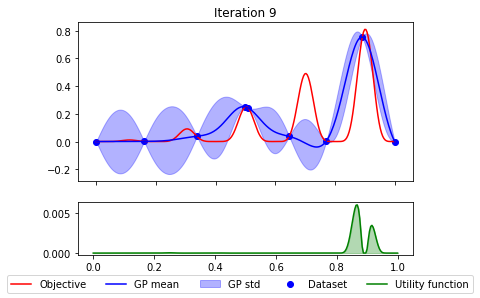

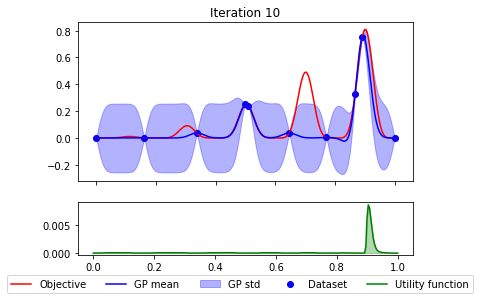

In [12]:
# sklearn might throw some annoying warnings, let's surpress them
import warnings
warnings.filterwarnings("ignore")

# give an initial guess of 0.5 and optimize
maximum, _ = bo.eval(10, 0.5)
print("\n--> Best Value found: ", maximum)

# plot the results
for i, state in enumerate(bo.states, start=1):
    bo.plot_state(state, i, show=False, additional_func=(objective, "Objective"))
plt.show()

The red line shows the objective function (as shown above), the blue line shows the mean of the GP, the light blue area shows the GP's standard deviation and the green line shows the EI utility function. Go through the images and track the way our optimizer works. On the last image you can see that our optimizer found $0.892$ as the best result after 10 iterations, which is quite near the global maximum at $0.9$. However, it is not guaranteed that the optimizer finds the global maximum on a small number of iterations. It might only find a local maximum, as the one at $0.5$. Okay, now we can go on to the main part of this blog. 

___
# Using Bayesian Optimization to find the Optimal Learning Rate

We want to find an optimal (or near optimal) learning rate for our classification task on K-MNIST. Therefore, we need to think more thoroughly about what our objective functions is. As mentioned before, we are using the loss $L$. But which loss exactly? The one calculated on a batch? Or the one after ten batches? Are we using the training or the validation loss?

Well, our main goal in a classification task is to decrease the loss on validation data. And even though, function evaluation is expensive, K-MNIST is a rather small dataset. This is why we are going to evaluate on the **validation loss after training one epoch**. In doing so, we are optimizing the learning rate with respect to the loss we care most about and on all data provided.

That is, our function to evaluate, which is given to the Bayesian optimizer, takes the learning rate and the dataset (training + validation) as the input and returns the average validation loss (as well as the torch model). As we are evaluating on one epoch, the function is called `run_one_epoch()`, as shown below.

Note that, our function is returning the negative loss since our optimizer tries to maximize the objective function (and we are interested in a small loss). Moreover, we are also calculating the accuracy, as it is more human-readable.

In [13]:
def accuracy(pred, true):
    class_index_pred = pred.detach().numpy().argmax(axis=1)
    return np.sum(true.detach().numpy() == class_index_pred) / len(pred)

def run_one_epoch(lr, train_l, val_l, seed):
    """
    Runs one epoch of training using the specified learning rate lr and returns the negative average
    validation loss.

    Parameters
    ----------
    lr: float
        Learning rate of the model.

    train_l: DataLoader
        Torch's DataLoaders constituting an iterator over the training dataset.

    val_l: DataLoader
        Torch's DataLoaders constituting an iterator over the validation dataset.

    seed: int
        Seed for Numpy and Torch.

    Returns
    -------
    Tuple containing the negative validation loss and the model trained on the specified learning rate.
    """
    # set the seed to initialize same model and randomness on all epochs to allow fair comparison
    np.random.seed(seed)
    torch.manual_seed(seed)

    # get our model and define the optimizer as well as the loss criterion
    model = ResNet9(in_channels=1, num_classes=10)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_loop = tqdm(train_l)  # tqdm wrapper used to print progress bar
    for data in train_loop:
        # unpack images and labels
        images, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # calculate loss
        outputs = model(images)
        loss = criterion(outputs, labels)

        # calculate and apply the gradients
        loss.backward()
        optimizer.step()

        # print some training information
        train_loop.set_postfix({"Loss": loss.item(), "Accuracy": accuracy(outputs, labels)})

    # let's validate our model
    print("Validating ...")
    with torch.no_grad():
        cum_val_loss = 0.0
        cum_acc = 0.0
        for data in val_l:
            # unpack images and labels
            images, labels = data

            # calculate loss
            outputs = model(images)
            cum_val_loss += criterion(outputs, labels)
            cum_acc += accuracy(outputs, labels)

        # print some validation information
        avg_val_loss = cum_val_loss / len(val_loader)
        avg_val_acc = cum_acc / len(val_loader)
        print("---> Validation-Loss: %.4f & Validation-Accuracy: %.4f" % (avg_val_loss, avg_val_acc))
        print("\n", "-"*60,"\n")

    return -avg_val_loss, model

Basically, the `run_one_epoch()` method consists of two loops; the training and the validation loop. While the model is optimized during the training loop, it is kept fixed during validation.  We have everything needed now to find the optimal learning rate. However, as for our example, we need to define a kernel, a GP and some bounds. As can be seen from our bounds defined below, our search space covers learning rates from $0.00001$ to $1.0$ since learning rates smaller than that are very uncommon on the first epoch. Let's run it for 10 iterations and see what happens!


BO Iteration 0 --> Chosen parameter: 0.751007 (randomly)



Validating ...
---> Validation-Loss: 0.6868 & Validation-Accuracy: 0.8006

 ------------------------------------------------------------ 


BO Iteration 1 --> Chosen parameter: 0.000010 



Validating ...
---> Validation-Loss: 1.7884 & Validation-Accuracy: 0.4542

 ------------------------------------------------------------ 


BO Iteration 2 --> Chosen parameter: 1.000000 



Validating ...
---> Validation-Loss: 1.1138 & Validation-Accuracy: 0.6793

 ------------------------------------------------------------ 


BO Iteration 3 --> Chosen parameter: 0.514061 



Validating ...
---> Validation-Loss: 0.8703 & Validation-Accuracy: 0.7545

 ------------------------------------------------------------ 


BO Iteration 4 --> Chosen parameter: 0.670686 



Validating ...
---> Validation-Loss: 1.0567 & Validation-Accuracy: 0.7085

 ------------------------------------------------------------ 


BO Iteration 5 --> Chosen parameter: 0.321292 



Validating ...
---> Validation-Loss: 0.4314 & Validation-Accuracy: 0.8712

 ------------------------------------------------------------ 


BO Iteration 6 --> Chosen parameter: 0.377516 



Validating ...
---> Validation-Loss: 0.5123 & Validation-Accuracy: 0.8473

 ------------------------------------------------------------ 


BO Iteration 7 --> Chosen parameter: 0.855423 



Validating ...
---> Validation-Loss: 1.0099 & Validation-Accuracy: 0.7073

 ------------------------------------------------------------ 


BO Iteration 8 --> Chosen parameter: 0.204827 



Validating ...
---> Validation-Loss: 0.2946 & Validation-Accuracy: 0.9147

 ------------------------------------------------------------ 


BO Iteration 9 --> Chosen parameter: 0.236955 



Validating ...
---> Validation-Loss: 0.3347 & Validation-Accuracy: 0.9043

 ------------------------------------------------------------ 


--> Found learning-rate after 10 iterations: 0.204827


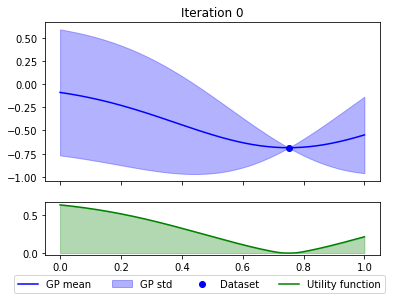

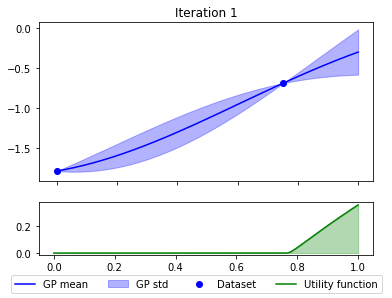

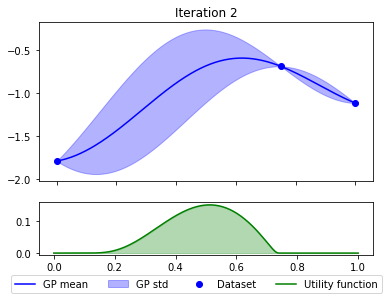

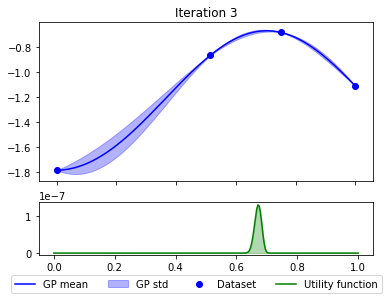

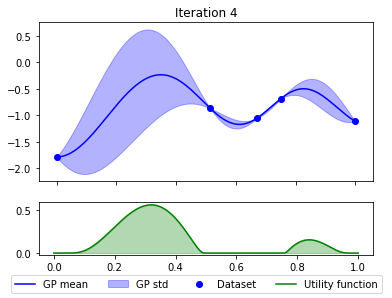

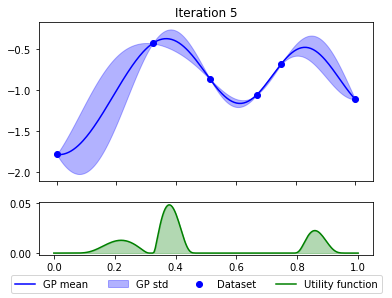

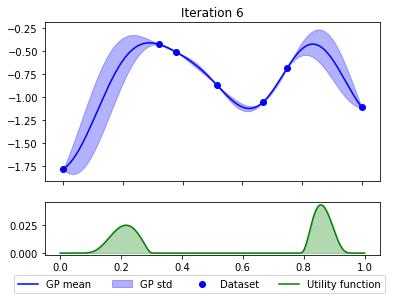

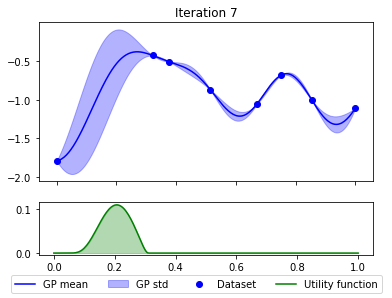

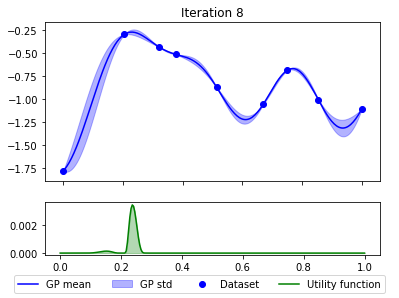

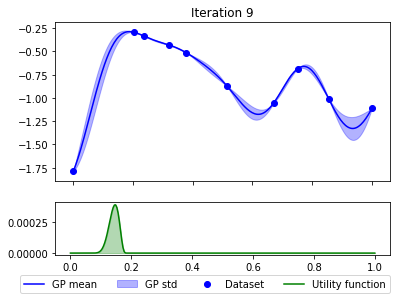

In [14]:
n_iter = 10  # number of iterations 
np.random.seed(seed) # set seed to allow fair comparison to logarithmic

# define the GP
kernel = C(1.0, (1e-5, 1e5)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel, n_restarts_optimizer=10)

# optmize the learning rate 
bo = BayesianOptimizer(lambda x: run_one_epoch(x, train_loader, val_loader, seed),
                       gp,
                       mode="linear",
                       bound=[1e-5, 1.0])

found_lr, best_model = bo.eval(n_iter=10)
print("\n--> Found learning-rate after %d iterations: %f" % (n_iter, found_lr))

# plot all iterations 
bo.plot_all()

# save the best model (this is the one returned from BO)
torch.save(best_model.state_dict(), "./ResNet9_linear")

Okay, let's take a look at the results. The optimizer is giving us a learning rate of $0.205$ that was achieved in the 8th iteration with a validation loss of $0.2946$ and an accuracy of $91.47\%$, which is quite good for the first epoch. However, I don't know about you, but I was wondering a bit about the way the optimizer was searching for the learning rate. If you take a closer look at the graph, you'll see that nearly all evaluations were done between $0.1$ and $1.0$. If you have ever tried to manually tune a learning rate on a classification task or at least read about commonly used learning rates, you'll find these learning rates quite huge. Moreover, you'll find the way the optimizer is searching for the optimal learning rate quite counterintuitive. Usually, we tune learning rates with an exponential decay, e.g., starting from $1\times 10^{-1}$ and going smaller to  $1\times 10^{-2}$,  $1\times 10^{-3}$, and so on.

Let's take a moment and think about why the optimizer is evaluating learning rates in a way, which might look counterintuitive to us. At first, let's take a closer look at the search space defined in the `BayesianOptimizer` class (for the linear case, ignore the logarithmic case for the moment). It uses **linear spacing**. Let's take a look at such a search space with the same bounds yet a smaller number of samples:

In [15]:
np.linspace(1e-5, 1.0, 100)

array([1.00000000e-05, 1.01109091e-02, 2.02118182e-02, 3.03127273e-02,
       4.04136364e-02, 5.05145455e-02, 6.06154545e-02, 7.07163636e-02,
       8.08172727e-02, 9.09181818e-02, 1.01019091e-01, 1.11120000e-01,
       1.21220909e-01, 1.31321818e-01, 1.41422727e-01, 1.51523636e-01,
       1.61624545e-01, 1.71725455e-01, 1.81826364e-01, 1.91927273e-01,
       2.02028182e-01, 2.12129091e-01, 2.22230000e-01, 2.32330909e-01,
       2.42431818e-01, 2.52532727e-01, 2.62633636e-01, 2.72734545e-01,
       2.82835455e-01, 2.92936364e-01, 3.03037273e-01, 3.13138182e-01,
       3.23239091e-01, 3.33340000e-01, 3.43440909e-01, 3.53541818e-01,
       3.63642727e-01, 3.73743636e-01, 3.83844545e-01, 3.93945455e-01,
       4.04046364e-01, 4.14147273e-01, 4.24248182e-01, 4.34349091e-01,
       4.44450000e-01, 4.54550909e-01, 4.64651818e-01, 4.74752727e-01,
       4.84853636e-01, 4.94954545e-01, 5.05055455e-01, 5.15156364e-01,
       5.25257273e-01, 5.35358182e-01, 5.45459091e-01, 5.55560000e-01,
      

You will quickly realize that most samples lie between $1\times 10^{-1}$ and $1\times 10^{0}$. This is due to the fact that linear spacing causes equidistant spreading, which is different to our logarithmic way of tuning. As you might know, this is an easy fix. We can just use logarithmic spacing (note that `np.logspace` is expecting you to give *exponents* as the bound):

In [16]:
# uses base 10 by default
np.logspace(-5,0, 100)

array([1.00000000e-05, 1.12332403e-05, 1.26185688e-05, 1.41747416e-05,
       1.59228279e-05, 1.78864953e-05, 2.00923300e-05, 2.25701972e-05,
       2.53536449e-05, 2.84803587e-05, 3.19926714e-05, 3.59381366e-05,
       4.03701726e-05, 4.53487851e-05, 5.09413801e-05, 5.72236766e-05,
       6.42807312e-05, 7.22080902e-05, 8.11130831e-05, 9.11162756e-05,
       1.02353102e-04, 1.14975700e-04, 1.29154967e-04, 1.45082878e-04,
       1.62975083e-04, 1.83073828e-04, 2.05651231e-04, 2.31012970e-04,
       2.59502421e-04, 2.91505306e-04, 3.27454916e-04, 3.67837977e-04,
       4.13201240e-04, 4.64158883e-04, 5.21400829e-04, 5.85702082e-04,
       6.57933225e-04, 7.39072203e-04, 8.30217568e-04, 9.32603347e-04,
       1.04761575e-03, 1.17681195e-03, 1.32194115e-03, 1.48496826e-03,
       1.66810054e-03, 1.87381742e-03, 2.10490414e-03, 2.36448941e-03,
       2.65608778e-03, 2.98364724e-03, 3.35160265e-03, 3.76493581e-03,
       4.22924287e-03, 4.75081016e-03, 5.33669923e-03, 5.99484250e-03,
      

Great! We can now evaluate each exponent equally in our search space, similar to what we would do when manually tuning the learning rate. 

However, we can't just use logarithmic spacing. Something you might not know (because we skipped it here) is that the main component for calculating the covariance in GPs is the *kernel*. As mentioned before, we took a RBF kernel (Constant kernel is not important here). Let's take a look at the kernel function for our case

\begin{equation}
k(\lambda_i, \lambda_j) = \exp\left( - \frac{d(\lambda_i, \lambda_j)^2}{2l^2} \right)\, .
\end{equation}

$\lambda_i$ and $\lambda_j$ are two learning rates, $d(.,.)$ is the Euclidean distance between those points and $l$ is the length parameter for scaling the covariance.

The part I want to point your attention to is the distance $d(.,.)$. As for a lot of kernels, this is the main metric for calculating the covariance between two points. Our intention when using logarithmic spacing is that we would like to explore each exponent equally. However, because our kernel is using the distance for calculating the covariance, it yields higher covariance for greater distance and vice versa. And since Expected Improvement yields higher utility with higher variance (c.f., equations above), our optimizer would still favour greater exponents.

However, the fix is easy here as well. We can simply **transform the search space logarithmically** when working with GPs. That is, the kernel is computed on a transformed learning rate $\psi(\lambda) = (\log_{10}(\lambda))$. The kernel is then

\begin{equation}
k(\psi(\lambda_i), \psi(\lambda_j)) = \exp\left( - \frac{d(\psi(\lambda_i), \psi(\lambda_j))^2}{2l^2} \right)\, .
\end{equation}

Note that we do not transform the targets during GP fitting. This means that the loss is equal for both cases $L(\lambda) = L(\psi(\lambda))$.

Let's recap briefly before we try that. 

1. We are using logarithmic *spacing* to have a search space, which contains the same amount of data points for each exponent. In doing so, we pay equal attention to each exponent.

2. We are using logarithmic *feature transformation* when working with GPs. This turns our non-linearly (here logarithmically) spaced search space into a linearly spaced search space. In doing so, we are encouraging the optimizer to search on small exponents as well.

Okay, enough theory! Let's see the results. Everything needed is already implemented in the `BayesianOptimizer` class. We only need to switch the mode from linear to logarithmic and change the bounds to exponents.


BO Iteration 0 --> Chosen parameter: 0.056888 (randomly)



Validating ...
---> Validation-Loss: 0.2114 & Validation-Accuracy: 0.9375

 ------------------------------------------------------------ 


BO Iteration 1 --> Chosen parameter: 0.000010 



Validating ...
---> Validation-Loss: 1.7884 & Validation-Accuracy: 0.4542

 ------------------------------------------------------------ 


BO Iteration 2 --> Chosen parameter: 1.000000 



Validating ...
---> Validation-Loss: 1.1138 & Validation-Accuracy: 0.6793

 ------------------------------------------------------------ 


BO Iteration 3 --> Chosen parameter: 0.003718 



Validating ...
---> Validation-Loss: 0.1843 & Validation-Accuracy: 0.9445

 ------------------------------------------------------------ 


BO Iteration 4 --> Chosen parameter: 0.013568 



Validating ...
---> Validation-Loss: 0.1893 & Validation-Accuracy: 0.9432

 ------------------------------------------------------------ 


BO Iteration 5 --> Chosen parameter: 0.000464 



Validating ...
---> Validation-Loss: 0.4587 & Validation-Accuracy: 0.8686

 ------------------------------------------------------------ 


BO Iteration 6 --> Chosen parameter: 0.001617 



Validating ...
---> Validation-Loss: 0.2530 & Validation-Accuracy: 0.9279

 ------------------------------------------------------------ 


BO Iteration 7 --> Chosen parameter: 0.164766 



Validating ...
---> Validation-Loss: 0.2699 & Validation-Accuracy: 0.9199

 ------------------------------------------------------------ 


BO Iteration 8 --> Chosen parameter: 0.000048 



Validating ...
---> Validation-Loss: 1.1590 & Validation-Accuracy: 0.6581

 ------------------------------------------------------------ 

Warning! Utilization function is all zero. Returning a random point for evaluation.

BO Iteration 9 --> Chosen parameter: 0.000211 



Validating ...
---> Validation-Loss: 0.6621 & Validation-Accuracy: 0.8066

 ------------------------------------------------------------ 


--> Found learning-rate after 10 iterations: 0.003718


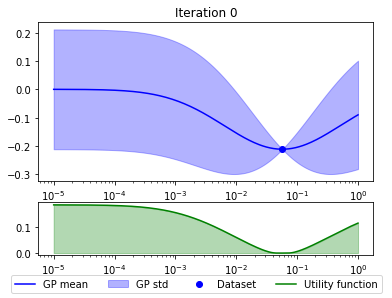

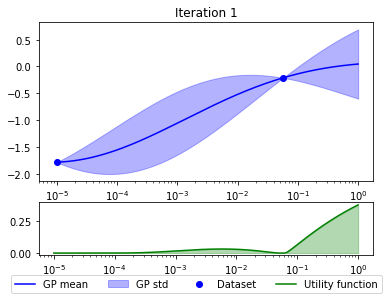

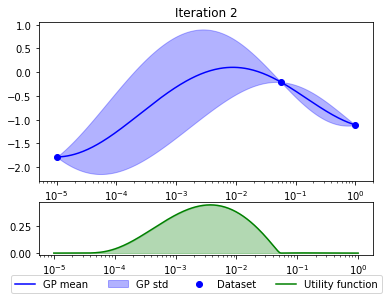

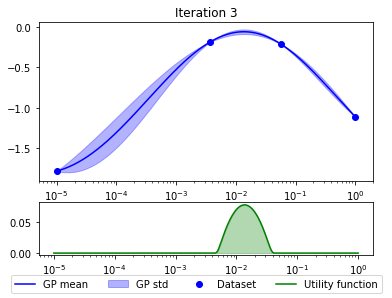

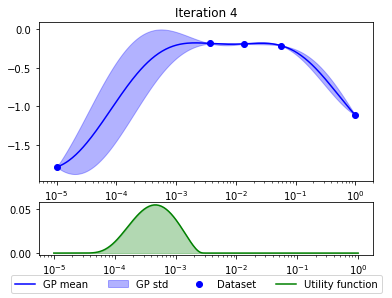

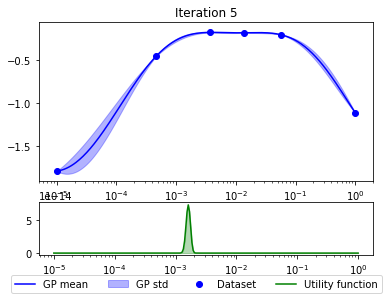

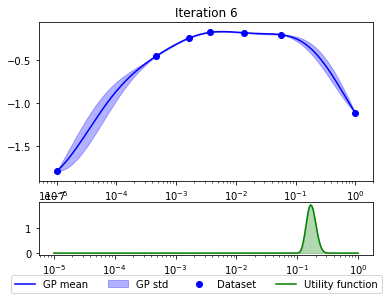

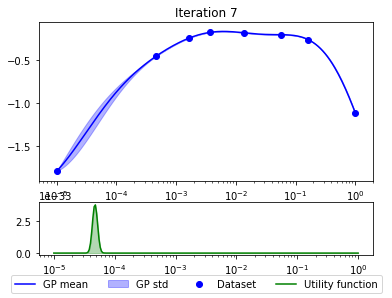

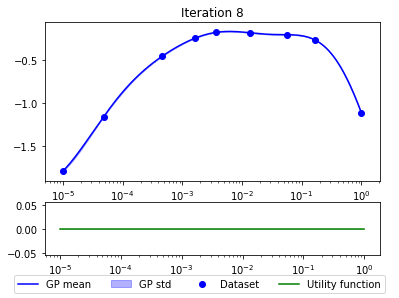

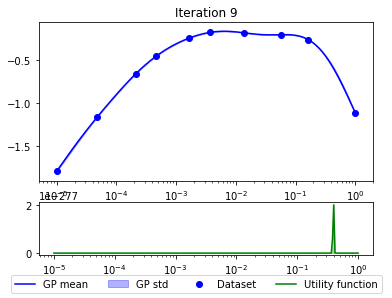

In [17]:
n_iter = 10  # number of iterations     
np.random.seed(seed) # set seed to allow fair comparison to linear

# define the GP
kernel = C(1.0, (1e-5, 1e5)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel, n_restarts_optimizer=10)

# optmize the learning rate 
bo = BayesianOptimizer(lambda x: run_one_epoch(x, train_loader, val_loader, seed),
                       gp,
                       mode="logarithmic",
                       bound=[-5, 0])

found_lr, best_model = bo.eval(n_iter=10)
print("\n--> Found learning-rate after %d iterations: %f" % (n_iter, found_lr))

# plot all iterations 
bo.plot_all()

# save the best model (this is the one returned from BO)
torch.save(best_model.state_dict(), "./ResNet9_log")

Yeay! We were able to decrease the loss from $0.2946$ to $0.1843$ and increase our accuracy from $91.47\%$ to $94.45\%$. The learning rate found is significantly smaller then the one found before: linear-mode $\rightarrow 0.204$ vs. logarithmic-mode $\rightarrow 0.0037$! Especially in the first iterations, you can see the that the variance is high in *both* directions, which is exactly what we wanted. In the last iteration, you can see that our optmizer paid equal attention to all exponents in our search space.

## Conclusion

One might argument that the difference between linear and logarithmic mode in performance isn't that high. Actually, that's true. However, paying more attention to smaller learning rates becomes more important in later epochs, where greater learning rates often cause stagnation in learning. 

Finally, I want to point out that, even though it might be useful to exploit our domain knowledge to transform the learning rate's search space logarithmically, it might be different for other hyperparameters, which we want to optimize as well. So, be careful with that! 